<a href="https://www.kaggle.com/code/trietp1253201581/regression-of-used-car-prices-s4e9?scriptVersionId=195103280" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression of Used Car Prices

## Import library and read data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/playground-series-s4e9/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
raw_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
raw_df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [5]:
original_data_dir = '/kaggle/input/used-car-price-prediction-dataset/'
original_df = pd.read_csv(original_data_dir + 'used_cars.csv')

In [6]:
def draw_numeric_features(data, x=None, y=None, overlap=None):
    plt.figure(figsize=(30,10))
    plt.grid()
    sns.lineplot(data, x=x, y=y)
    if overlap is not None:
        for plot in overlap:
            sns.lineplot(data=plot[0], x=plot[1], y=plot[2])

def view_avg_of_each(cat_features: str, target: str):
    d = dict()
    cols = raw_df[cat_features].unique()
    for x in cols:
        d[x] = raw_df[raw_df[cat_features]==x][target].mean()
    return pd.Series(d, index=cols)

In [7]:
raw_df['price'].describe()

count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

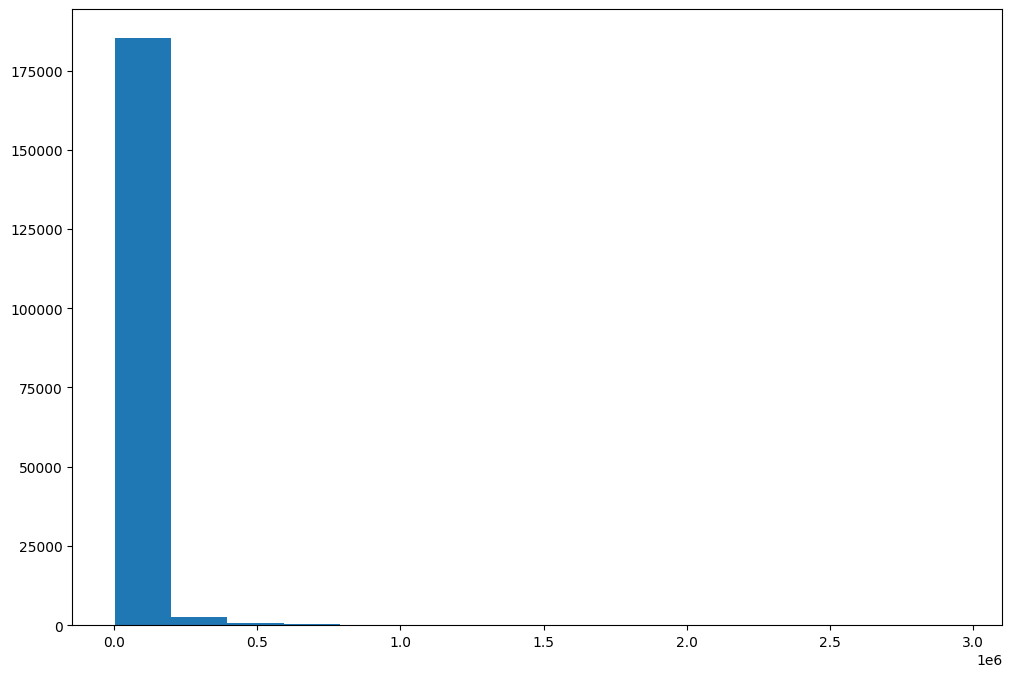

In [8]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['price'], bins=15);

In [9]:
numeric_features = []
categorical_features = []
original_features = raw_df.columns.tolist()

## EDA & Feature Engineering

### Brand

In [10]:
len(raw_df['brand'].unique())

57

In [11]:
raw_df['brand'].value_counts().head()

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Name: count, dtype: int64

In [12]:
famous_brands = ['Ford','Ferrari','McLaren','Rolls-Royce','Lamborghini',
                 'Bentley','Ford','Mercedes-Benz','BMW','Chevrolet',
                 'Audi','Porsche','Toyota','Cadillac','Maserati','Lexus','Tesla',
                 'Aston','Bugatti']

In [13]:
for df in [raw_df, test_df, original_df]:
    df['is_famous_brand'] = df['brand'].apply(lambda x: 1 if x in famous_brands else 0)

In [14]:
view_avg_of_each('is_famous_brand', 'price')

0    36510.456279
1    47418.654699
dtype: float64

In [15]:
categorical_features.append('brand')
numeric_features.append('is_famous_brand')

### Model

In [16]:
len(raw_df['model'].unique())

1897

In [17]:
raw_df['model'].value_counts().sort_values(ascending=False).head()

model
F-150 XLT             2945
M3 Base               2229
Camaro 2SS            1709
M4 Base               1622
Mustang GT Premium    1526
Name: count, dtype: int64

In [18]:
for df in [raw_df, test_df, original_df]:
    df['short_model'] = df['model'].apply(lambda x: str(x).split(' ')[0])

In [19]:
len(raw_df['short_model'].unique())

517

In [20]:
popular_short_models = raw_df['short_model'].value_counts().sort_values(ascending=False).head(40).index.tolist()

In [21]:
for df in [raw_df, test_df, original_df]:
    df['is_popular_short_model'] = df['short_model'].apply(lambda x: 1 if x in popular_short_models else 0)

In [22]:
view_avg_of_each('is_popular_short_model', 'price')

0    39007.577769
1    48220.640914
dtype: float64

In [23]:
categorical_features += ['model', 'short_model']
numeric_features.append('is_popular_short_model')

### Model year

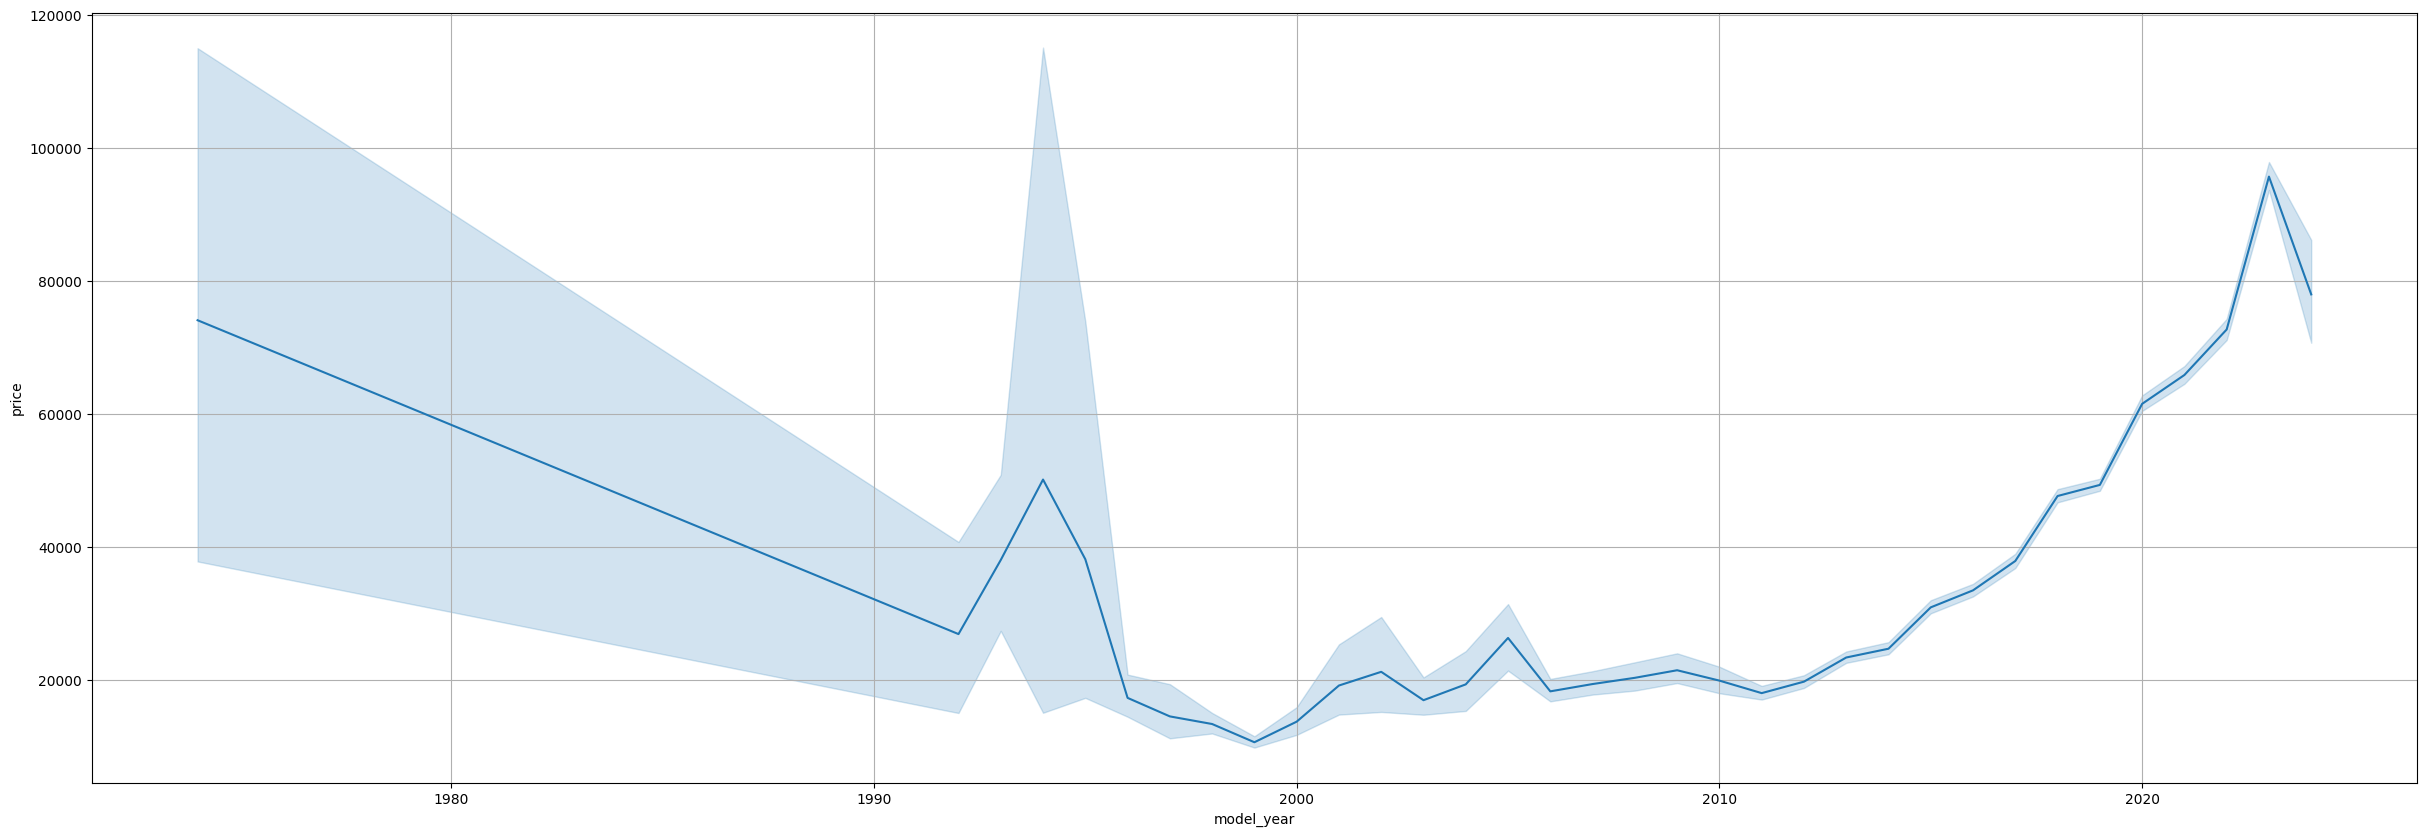

In [24]:
draw_numeric_features(data=raw_df, x='model_year', y='price')

In [25]:
def get_year_group(x):
    if x<=1986:
        return 0
    if x<=1995:
        return 1
    if x<=2004:
        return 2
    if x<=2012:
        return 3
    if x<=2019:
        return 4
    if x<=2022:
        return 5
    return 6

In [26]:
def get_assessing_epreciation_percent(x):
    if x<=3:
        return 6.5 * x
    if x<=7:
        return 6 * (x - 3) + 6.5 * 3
    if x<=10:
        return 8.5 * (x-7) + 6 * 4 + 6.5 * 3
    return 8.5 * 3 + 6 * 4 + 6.5 * 3 + 0.15 * (x-10)

In [27]:
for df in [raw_df, test_df, original_df]:
    df['age'] = df['model_year'].apply(lambda x: 2024-x)
    df['model_year_group'] = df['model_year'].apply(lambda x: get_year_group(x))
    df['assessing_epreciation_percent'] = df['age'].apply(lambda x: get_assessing_epreciation_percent(x))

In [28]:
view_avg_of_each('model_year_group','price')

3    20153.641926
2    17859.240809
4    37791.474344
5    66676.368290
6    95386.817378
1    40873.508621
0    74124.083333
dtype: float64

In [29]:
numeric_features += ['age','model_year_group','assessing_epreciation_percent']

### Mileage

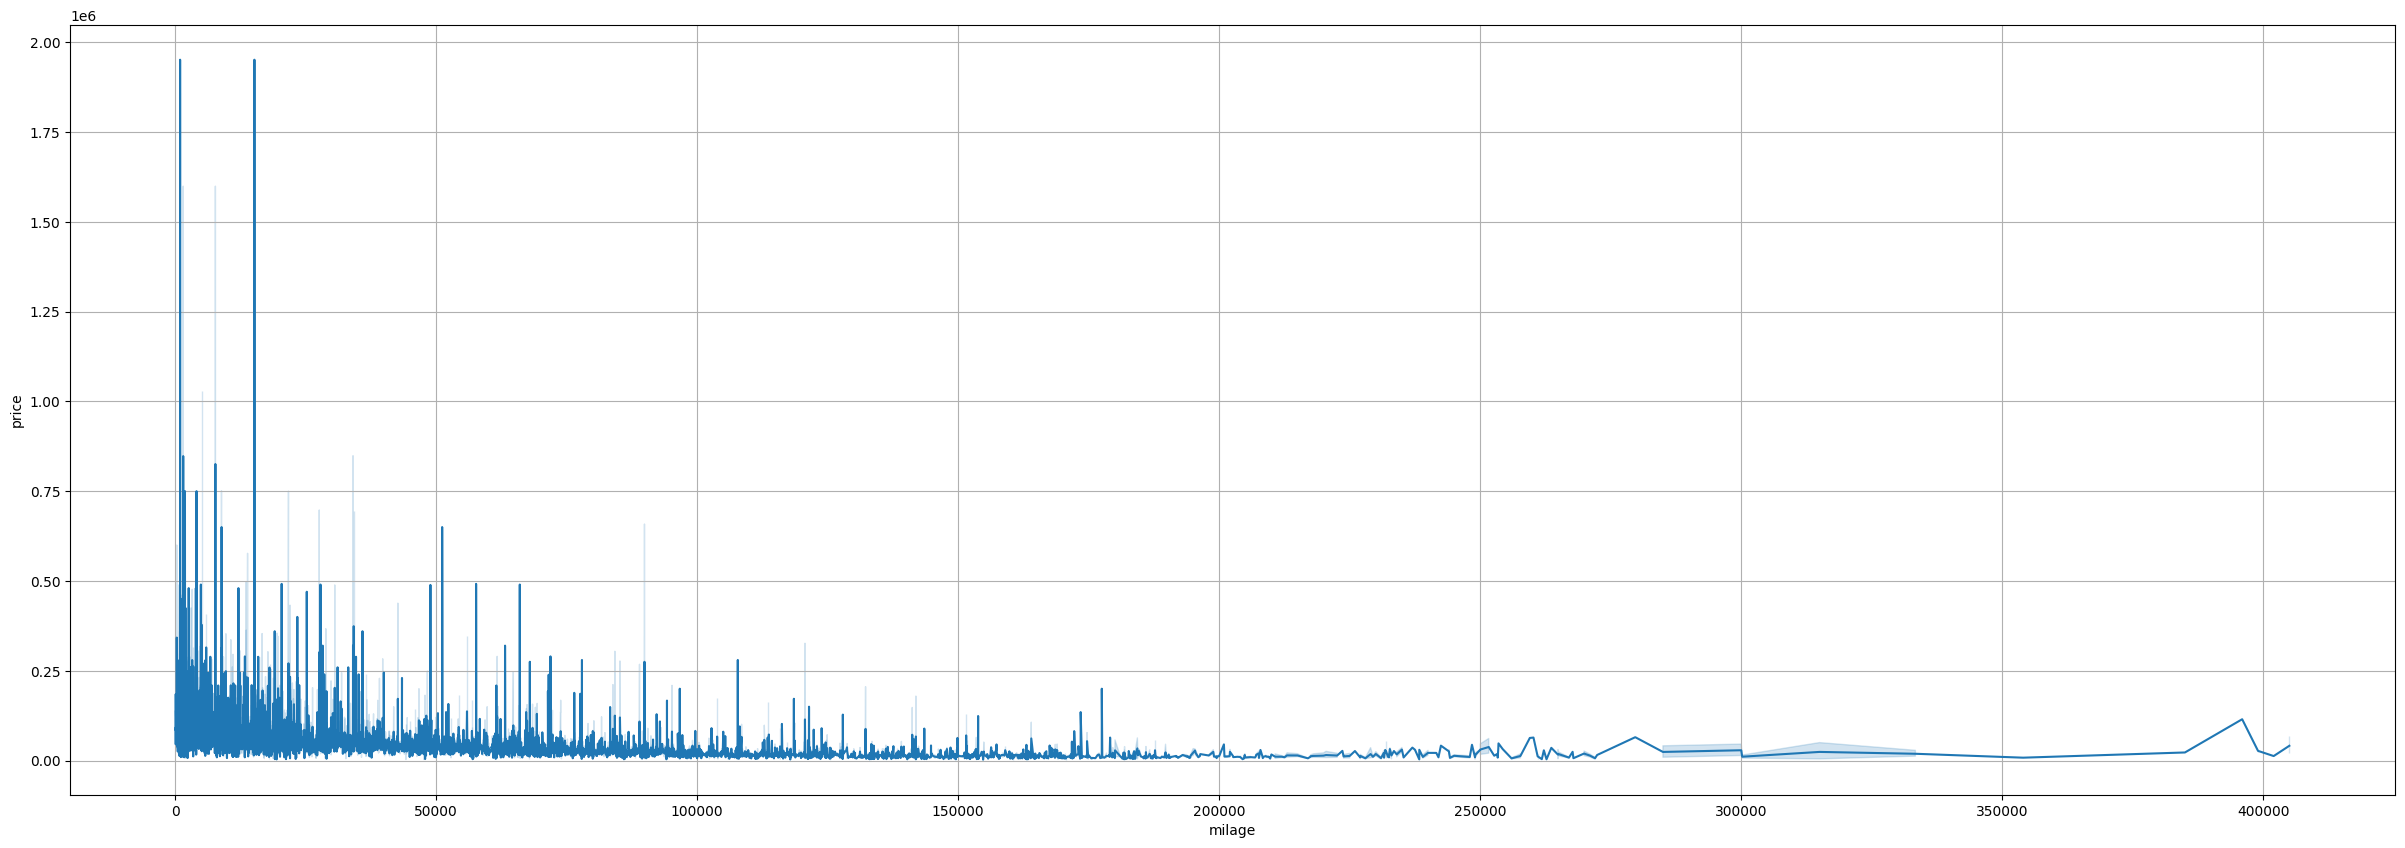

In [30]:
draw_numeric_features(data=raw_df, x='milage', y='price')

In [31]:
def help_change_milage(x):
    milage_str = str(x).split(' ')[0]
    milage_lst = milage_str.split(',')
    if len(milage_lst) >= 2:
        return int(milage_lst[0]) * 1000 + int(milage_lst[1])
    return int(milage_lst[0])
original_df['milage'] = original_df['milage'].apply(lambda x: help_change_milage(x))

In [32]:
def get_milage_group(x):
    if x<=20000:
        return 4
    if x<=70000:
        return 3
    if x<=120000:
        return 2
    if x<=190000:
        return 1
    return 0

In [33]:
for df in [raw_df, test_df, original_df]:
    df['milage_group'] = df['milage'].apply(lambda x: get_milage_group(x))

In [34]:
view_avg_of_each('milage_group','price')

0    13805.392821
1    14252.966050
4    83439.145064
3    46213.138404
2    24330.013339
dtype: float64

In [35]:
numeric_features += ['milage','milage_group']

### Fuel Type

In [36]:
raw_df['fuel_type'].isna().sum()

5083

In [37]:
raw_df['fuel_type'].value_counts(dropna=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [38]:
for df in [raw_df, test_df, original_df]:
    df['fuel_type'] = df['fuel_type'].apply(lambda x: 'rem' if (x==np.nan or str(x)=='nan') else x)

In [39]:
view_avg_of_each('fuel_type', 'price')

Gasoline          43360.013782
E85 Flex Fuel     26729.755457
rem               60822.612040
Hybrid            55473.451698
Diesel            48769.587358
Plug-In Hybrid    44150.967370
–                 36414.285531
not supported     20692.733333
dtype: float64

In [40]:
categorical_features.append('fuel_type')

### Engine

In [41]:
raw_df['engine'].isna().sum()

0

In [42]:
def split_engine(x, need_find: str):
    result = {'HP':np.nan, 'L':np.nan, 'EngineType': 'rem'}
    x_lst = str(x).split(' ')
    idx_find = {'HP':-1, 'L':-1, 'EngineType':-1}
    for i in range(len(x_lst)):
        e = x_lst[i]
        if e.find('HP')>=0 and idx_find['HP']==-1:
            result['HP'] = e.split('HP')[0]
            idx_find['HP'] = i
        elif e.find('L')>0 and idx_find['L']==-1:
            result['L'] = e.split('L')[0]
            idx_find['L'] = i
        elif e == 'Liter' and idx_find['L']==-1 and i>=1:
            result['L'] = x_lst[i-1]
            idx_find['L'] = i
        elif e in ['Cylinder', 'SOHC', 'DOHC', 'OHV', 'Electric'] and idx_find['EngineType']==-1:
            result['EngineType'] = e
            idx_find['EngineType'] = i
        else:
            continue
    return result[need_find]

In [43]:
for df in [raw_df, test_df, original_df]:
    df['HP'] = df['engine'].apply(lambda x: split_engine(x, 'HP'))
    df['HP'] = df['HP'].astype('float32')
    df['L'] = df['engine'].apply(lambda x: split_engine(x, 'L'))
    df['L'] = df['L'].astype('float32')
    df['EngineType'] = df['engine'].apply(lambda x: split_engine(x, 'EngineType'))

In [44]:
avg_hp_of_engine_type = raw_df.groupby('EngineType')['HP'].mean()
avg_hp_of_engine_type['DOHC']=420
avg_hp_of_engine_type['OHV']=600
avg_hp_of_engine_type['SOHC']=200
avg_hp_of_engine_type

EngineType
Cylinder    338.147766
DOHC        420.000000
Electric    509.035553
OHV         600.000000
SOHC        200.000000
rem         224.112671
Name: HP, dtype: float32

In [45]:
avg_l_of_engine_type = raw_df.groupby('EngineType')['L'].mean()
avg_l_of_engine_type

EngineType
Cylinder    3.821541
DOHC        3.304336
Electric    0.845652
OHV         5.825235
SOHC        3.340857
rem         2.998732
Name: L, dtype: float32

In [46]:
for df in [raw_df, test_df, original_df]:
    df['HP'] = df.apply(lambda x: x['HP'] if x['HP']>=0 else avg_hp_of_engine_type.get(x['EngineType']), axis=1)
    df['L'] = df.apply(lambda x: x['L'] if x['L']>=0 else avg_l_of_engine_type.get(x['EngineType']), axis=1)

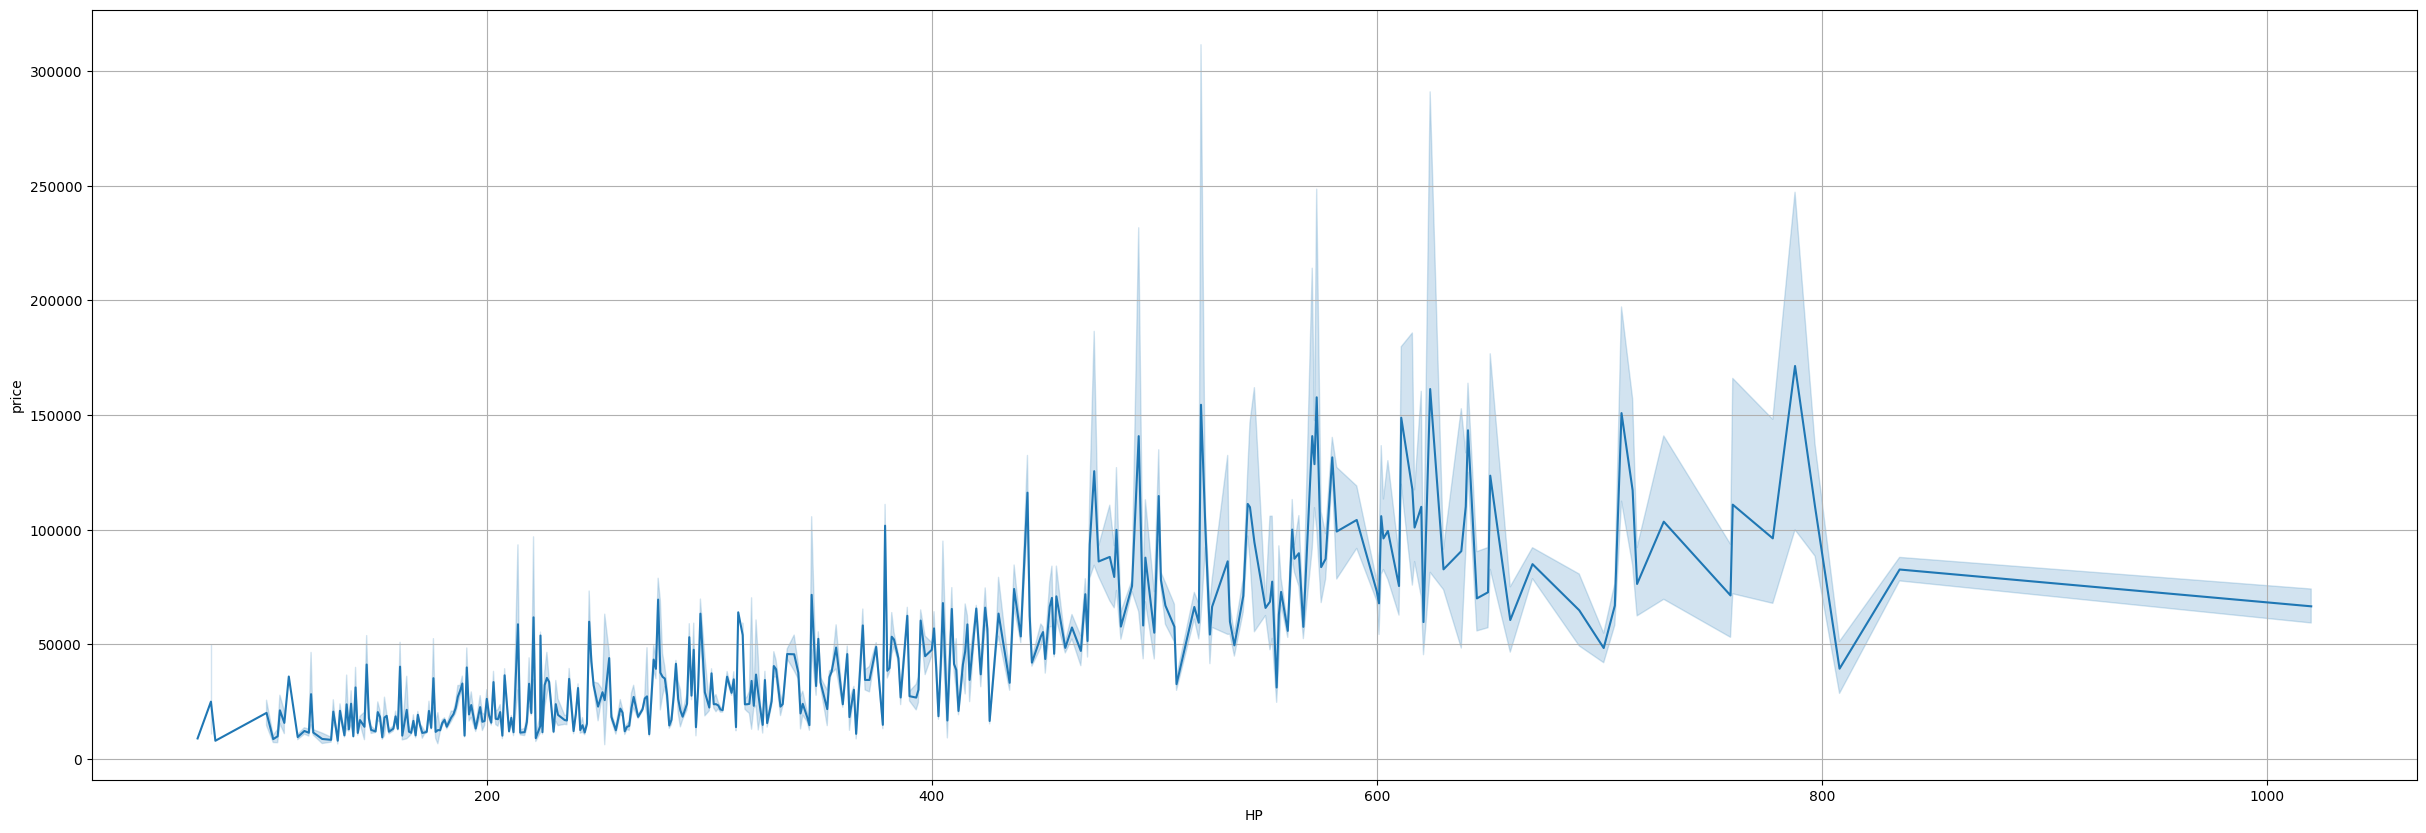

In [47]:
draw_numeric_features(raw_df, 'HP', 'price')

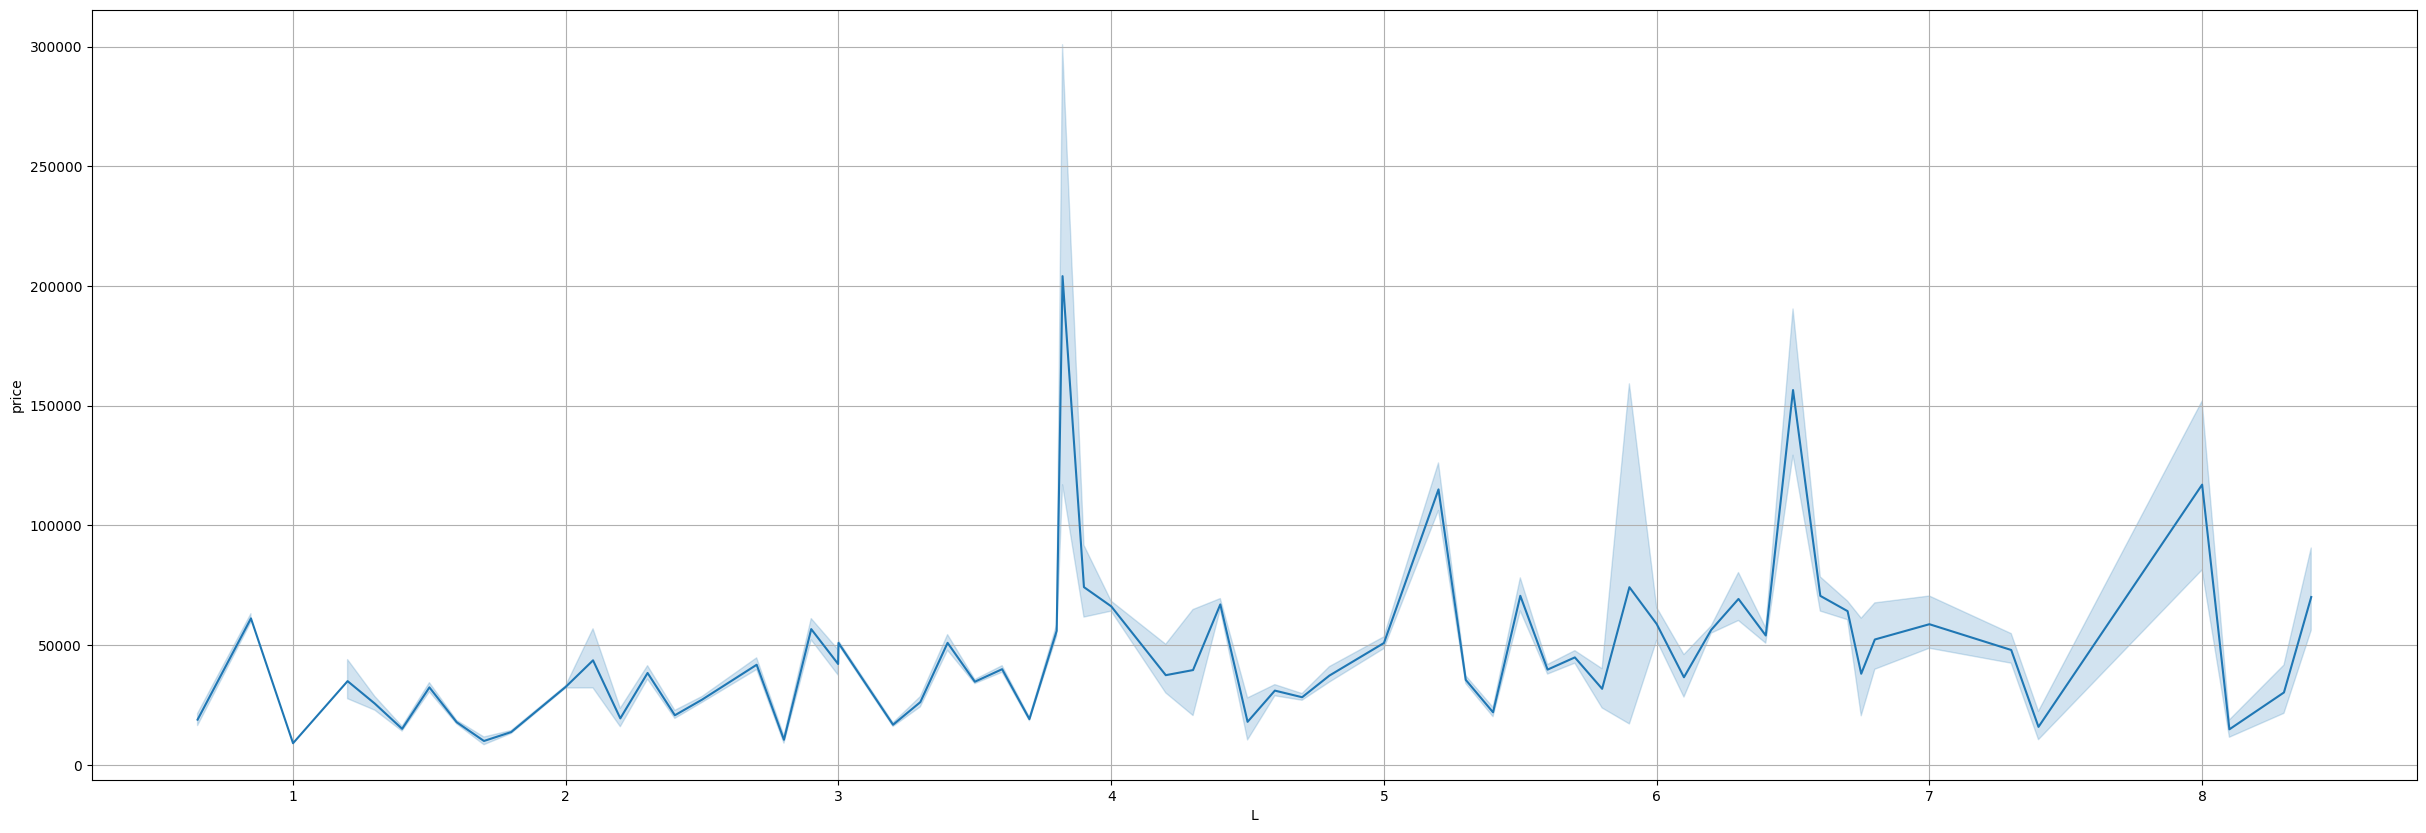

In [48]:
draw_numeric_features(raw_df, 'L', 'price')

In [49]:
view_avg_of_each('EngineType','price')

Cylinder    38861.091978
DOHC        68014.759650
Electric    60639.006215
OHV         70728.657875
rem         53557.271687
SOHC        54658.378913
dtype: float64

In [50]:
len(raw_df[['HP','L','EngineType']].value_counts()), len(raw_df['engine'].value_counts())

(929, 1117)

In [51]:
numeric_features += ['HP','L']
categorical_features += ['engine','EngineType']

### Transmission

In [52]:
len(raw_df['transmission'].unique())

52

In [53]:
def get_short_transmission(x):
    if x.find('Automatic')>=0:
        return 'Automatic'
    if x.find('Manual')>=0:
        return 'Manual'
    if x == 'Transmission w/Dual Shift Mode':
        return 'T'
    if (x.find('A/T')>=0) or (x.find('AT')>=0):
        return 'A/T'
    if (x.find('M/T')>=0) or (x.find('Mt')>=0):
        return 'M/T'
    return 'rem'

In [54]:
for df in [raw_df, test_df, original_df]:
    df['short_transmission'] = df['transmission'].apply(lambda x: get_short_transmission(x))

In [55]:
len(raw_df['short_transmission'].value_counts(dropna=False))

6

In [56]:
view_avg_of_each('short_transmission','price')

A/T           39084.048052
T             50201.815580
Automatic     64513.177039
rem           34728.122449
M/T           31410.735092
Manual       125875.796163
dtype: float64

In [57]:
categorical_features += ['transmission','short_transmission']

### Color

In [58]:
for df in [raw_df, test_df, original_df]:
    df['ext_col'] = df['ext_col'].apply(lambda x: str(x).lower())
    df['int_col'] = df['int_col'].apply(lambda x: str(x).lower())

In [59]:
len(raw_df['ext_col'].unique()), len(raw_df['int_col'].unique())

(317, 152)

In [60]:
ext_cols = raw_df['ext_col'].value_counts().head(60).index.tolist()
int_cols = raw_df['int_col'].value_counts().head(35).index.tolist()

In [61]:
for df in [raw_df, test_df, original_df]:
    df['short_ext_col'] = df['ext_col'].apply(lambda x: x if x in ext_cols else 'rem')
    df['short_int_col'] = df['int_col'].apply(lambda x: x if x in int_cols else 'rem')

In [62]:
categorical_features += ['ext_col','int_col','short_ext_col','short_int_col']

### Accident

In [63]:
raw_df['accident'].value_counts(dropna=False)

accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64

In [64]:
for df in [raw_df, test_df, original_df]:
    df['accident'] = df['accident'].apply(lambda x: 1 if x=='At least 1 accident or damage reported' else 0)

In [65]:
view_avg_of_each('accident','price')

0    49122.876550
1    25334.071475
dtype: float64

In [66]:
numeric_features.append('accident')

### Clean title

In [67]:
raw_df['clean_title'].value_counts(dropna=False)

clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64

In [68]:
for df in [raw_df, test_df, original_df]:
    df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x=='Yes' else 0)

In [69]:
view_avg_of_each('clean_title','price')

1    41354.406704
0    63567.566273
dtype: float64

In [70]:
numeric_features.append('clean_title')

In [71]:
len(numeric_features), len(categorical_features)

(11, 12)

### Interactive Features

In [72]:
brand_model_group_price = raw_df.groupby(['brand','short_model'])['price'].mean()
fuel_engine_transmission_group_price = raw_df.groupby(['fuel_type','EngineType','short_transmission'])['price'].mean()
fuel_engine_group_price = raw_df.groupby(['fuel_type','EngineType'])['price'].mean()

In [73]:
for df in [raw_df, test_df, original_df]:
    df['mile_per_year'] = df['milage'] / (df['age']+1)
    df['HP_per_L'] = df['HP'] / df['L']
    df['brand_model_price'] = df.apply(lambda x: brand_model_group_price.get((x['brand'],
                                                                              x['short_model'])), 
                                       axis=1)
    df['fuel_engine_transmission_price'] = df.apply(lambda x: fuel_engine_transmission_group_price.get((x['fuel_type'],
                                                                                                        x['EngineType'],
                                                                                                        x['short_transmission'])), 
                                                    axis=1)
    df['fuel_engine_price'] = df.apply(lambda x: fuel_engine_group_price.get((x['fuel_type'],
                                                                              x['EngineType'])),
                                       axis=1)

In [74]:
avg_brand_model_price = raw_df['brand_model_price'].mean()
avg_fuel_engine_transmission_price = raw_df['fuel_engine_transmission_price'].mean()
avg_fuel_engine_price = raw_df['fuel_engine_price'].mean()
test_df.fillna({'brand_model_price': avg_brand_model_price,
                'fuel_engine_transmission_price': avg_fuel_engine_transmission_price,
                'fuel_engine_price': avg_fuel_engine_price},
               inplace=True)

In [75]:
numeric_features += ['mile_per_year',
                     'HP_per_L',
                     'brand_model_price',
                     'fuel_engine_transmission_price',
                     'fuel_engine_price']

## Preprocessing

In [76]:
len(original_df)

4009

In [77]:
original_df['id'] = [i for i in range(314223,314223+4009)]

In [78]:
concat_cols = ['id'] + categorical_features + numeric_features

In [79]:
concat_df = pd.concat([raw_df[concat_cols], test_df[concat_cols], original_df[concat_cols]]).copy()
concat_df.head()

,id,brand,model,short_model,fuel_type,engine,EngineType,transmission,short_transmission,ext_col,...,milage_group,HP,L,accident,clean_title,mile_per_year,HP_per_L,brand_model_price,fuel_engine_transmission_price,fuel_engine_price
0,0,MINI,Cooper S Base,Cooper,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,Cylinder,A/T,A/T,yellow,...,0,172.0,1.6,0,1,11833.333333,107.499998,12765.967866,37871.390841,38600.009988
1,1,Lincoln,LS V8,LS,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,Cylinder,A/T,A/T,silver,...,1,252.0,3.9,1,1,6228.260870,64.615383,12914.757576,37871.390841,38600.009988
2,2,Chevrolet,Silverado 2500 LT,Silverado,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,Cylinder,A/T,A/T,blue,...,1,320.0,5.3,0,1,5944.826087,60.377356,42775.483638,25040.003270,25241.280210
3,3,Genesis,G90 5.0 Ultimate,G90,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Cylinder,Transmission w/Dual Shift Mode,T,black,...,4,420.0,5.0,0,1,2437.500000,84.000000,48911.521429,50007.655618,38600.009988
4,4,Mercedes-Benz,Metris Base,Metris,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Cylinder,7-Speed A/T,A/T,black,...,4,208.0,2.0,0,1,1847.000000,104.000000,64855.673077,37871.390841,38600.009988


In [80]:
encoder = OrdinalEncoder()
encoder.fit(concat_df[categorical_features])

OrdinalEncoder()

In [81]:
for df in [raw_df, test_df, original_df]:
    df[categorical_features] = encoder.transform(df[categorical_features])

In [82]:
all_features = numeric_features + categorical_features
len(all_features)

28

In [83]:
inputs, targets = raw_df[all_features], raw_df['price']

In [84]:
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
milage,0.680984
engine,0.651098
age,0.553656
assessing_epreciation_percent,0.550309
HP,0.531003
HP_per_L,0.505472
transmission,0.445267
model_year_group,0.419311
milage_group,0.391435
brand_model_price,0.366461


`fuel_type` and `accident` are 2 original features, so we keep them and only remove `is_popular_short_model` and `is_famous_brand`.

In [85]:
all_features.remove('is_popular_short_model')
all_features.remove('is_famous_brand')

In [92]:
original_features.remove('id')
original_features.remove('model_year')
original_features.remove('price')
original_features.append('age')
original_features

['brand',
 'model',
 'milage',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'age']

I have chosen a list of features that I fill important

In [96]:
importance_features = ['milage','age','assessing_epreciation_percent',
                       'HP','HP_per_L','transmission','model_year_group',
                       'engine','milage_group','brand_model_price',
                       'model','fuel_engine_transmission_price',
                       'fuel_engine_price','mile_per_year','clean_title',
                       'short_ext_col','short_int_col',
                       'brand','fuel_type','accident']
len(importance_features)

20

In [86]:
len(all_features)

26

In [87]:
def help_change_price(x):
    milage_str = str(x).split('$')[1]
    milage_lst = milage_str.split(',')
    if len(milage_lst) >= 2:
        return int(milage_lst[0]) * 1000 + int(milage_lst[1])
    return int(milage_lst[0])
original_df['price'] = original_df['price'].apply(lambda x: help_change_price(x))

## Training model and tunning hyperparameters

In [88]:
concat_df = pd.concat([raw_df, original_df]).copy()
concat_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,L,EngineType,short_transmission,short_ext_col,short_int_col,mile_per_year,HP_per_L,brand_model_price,fuel_engine_transmission_price,fuel_engine_price
0,0,31.0,495.0,2007,213000,2.0,117.0,38.0,313.0,69.0,...,1.6,0.0,0.0,59.0,16.0,11833.333333,107.499998,12765.967866,37871.390841,38600.009988
1,1,28.0,930.0,2002,143250,2.0,370.0,38.0,264.0,8.0,...,3.9,0.0,0.0,51.0,0.0,6228.260870,64.615383,12914.757576,37871.390841,38600.009988
2,2,9.0,1575.0,2002,136731,1.0,653.0,38.0,36.0,69.0,...,5.3,0.0,0.0,10.0,16.0,5944.826087,60.377356,42775.483638,25040.003270,25241.280210
3,3,16.0,758.0,2017,19500,2.0,878.0,59.0,26.0,12.0,...,5.0,0.0,4.0,5.0,1.0,2437.500000,84.000000,48911.521429,50007.655618,38600.009988
4,4,36.0,1077.0,2021,7388,2.0,263.0,23.0,26.0,8.0,...,2.0,0.0,0.0,5.0,0.0,1847.000000,104.000000,64855.673077,37871.390841,38600.009988


In [89]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(raw_df[all_features],
                                                                        raw_df['price'],
                                                                        test_size=0.2,
                                                                        random_state=42)

In [90]:
train_inputs.shape, val_inputs.shape

((150826, 26), (37707, 26))

In [99]:
regressor = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_jobs=-1),
    'XGBRegressor': XGBRegressor(n_jobs=-1),
    'LGBMRegressor': LGBMRegressor(n_jobs=-1, verbose=0),
    'CatBoostRegressor': CatBoostRegressor(logging_level='Silent')
}
result = {'Regressor': [], 
          'RMSE with all features': [], 
          'RMSE with original features': [], 
          'RMSE with importance features': []}

In [100]:
%%time
for reg_name, reg in regressor.items():
    result['Regressor'].append(reg_name)
    # Fit with all features
    reg.fit(train_inputs, train_targets)
    val_preds = reg.predict(val_inputs)
    loss_all_features = np.sqrt(mean_squared_error(val_targets, val_preds))
    result['RMSE with all features'].append(loss_all_features)
    # Fit with original features
    reg.fit(train_inputs[original_features], train_targets)
    val_preds = reg.predict(val_inputs[original_features])
    loss_original_features = np.sqrt(mean_squared_error(val_targets, val_preds))
    result['RMSE with original features'].append(loss_original_features)
    # Fit with importance features
    reg.fit(train_inputs[importance_features], train_targets)
    val_preds = reg.predict(val_inputs[importance_features])
    loss_importance_features = np.sqrt(mean_squared_error(val_targets, val_preds))
    result['RMSE with importance features'].append(loss_importance_features)
result_df = pd.DataFrame(result)
result_df

CPU times: user 11min 39s, sys: 9.81 s, total: 11min 49s
Wall time: 9min 15s


,Regressor,RMSE with all features,RMSE with original features,RMSE with importance features
0,LinearRegression,68627.417801,70231.528779,68669.449752
1,Ridge,68627.419707,70231.529506,68669.451513
2,DecisionTreeRegressor,117233.100210,110634.288502,113328.587417
3,RandomForestRegressor,73978.980612,74953.553781,73891.394557
4,XGBRegressor,71674.157562,70700.671465,71262.143699
5,LGBMRegressor,67779.318956,67989.922688,67812.921877
6,CatBoostRegressor,68226.936501,68271.231216,68418.862670


So we choose all features

### Linear Regression

In [101]:
reg = LinearRegression()
reg.fit(train_inputs, train_targets)

LinearRegression()

In [102]:
train_preds = reg.predict(train_inputs)
train_loss = np.sqrt(mean_squared_error(train_targets, train_preds))
val_preds = reg.predict(val_inputs)
val_loss = np.sqrt(mean_squared_error(val_targets, val_preds))
train_loss, val_loss

(74391.69943332604, 68627.41780141521)

In [144]:
def cross_validation(reg, cv, inputs, targets, test_inputs):
    train_losses = []
    val_losses = []
    test_preds = np.zeros(len(test_inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        reg.fit(X_train, y_train)

        train_pred = reg.predict(X_train)
        train_loss = np.sqrt(mean_squared_error(y_train, train_pred))
        train_losses.append(train_loss)
        val_pred = reg.predict(X_val)
        val_loss = np.sqrt(mean_squared_error(y_val, val_pred))
        val_losses.append(val_loss)

        print(f'Fold {fold}: train_loss = {train_loss:.5f}, val_loss = {val_loss:.5f}')

        test_pred = reg.predict(test_inputs)
        test_preds += test_pred/cv.get_n_splits()

    m_train_loss = np.mean(train_losses)
    s_train_loss = np.std(train_losses)
    m_val_loss = np.mean(val_losses)
    s_val_loss = np.std(val_losses)
    print(f'Train loss: {m_train_loss:.7f} ± {s_train_loss:.7f} | Val loss: {m_val_loss:.7f} ± {s_val_loss:.7f}')
    return test_preds

In [108]:
inputs, targets = raw_df[all_features], raw_df['price']
test_inputs = test_df[all_features]

In [110]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [111]:
%%time
reg = LinearRegression()
test_preds = cross_validation(reg, cv, inputs, targets, test_inputs)

Fold 0: train_loss = 73206.54150, val_loss = 73546.41290
Fold 1: train_loss = 73216.00281, val_loss = 73511.58883
Fold 2: train_loss = 73317.85902, val_loss = 73108.51763
Fold 3: train_loss = 73407.65529, val_loss = 72757.78505
Fold 4: train_loss = 73205.94211, val_loss = 73558.01994
Train loss: 73270.8001479 ± 80.3521671 | Val loss: 73296.4648717 ± 317.0689195
CPU times: user 4.1 s, sys: 1.2 s, total: 5.31 s
Wall time: 2.11 s


In [112]:
sub_df['price'] = test_preds
#sub_df.to_csv('/kaggle/working/sub1.csv', index=None)
sub_df.head()
#LB: 73539.61073

,id,price
0,188533,32315.534886
1,188534,77805.013743
2,188535,66467.677820
3,188536,23180.508868
4,188537,34565.654211


### XGBRegressor

In [113]:
param_grid = {
    'booster': ['gblinear'],
    'n_jobs': [-1],
    'reg_lambda': [0.25,0.5],
    'n_estimators': [100,250,500],
    'learning_rate': [0.05,0.15,0.3],
    'objective': ['reg:squarederror','reg:tweedie']
}
grid = GridSearchCV(XGBRegressor(), param_grid=param_grid, 
                    scoring='neg_root_mean_squared_error', cv=5,
                    refit=True, verbose=3)

In [ ]:
# Fit in 32min36s
#%%time
#grid.fit(inputs,targets)

In [ ]:
#grid.best_params_

In [116]:
%%time
reg = XGBRegressor(n_jobs=-1, booster='gblinear', reg_lambda=0.25, 
                   n_estimators=500)
reg.fit(inputs, targets, eval_set=[(val_inputs, val_targets)], verbose=False)

CPU times: user 24.6 s, sys: 76 ms, total: 24.7 s
Wall time: 24.7 s


XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [117]:
train_preds = reg.predict(train_inputs)
train_loss = np.sqrt(mean_squared_error(train_targets, train_preds))
val_preds = reg.predict(val_inputs)
val_loss = np.sqrt(mean_squared_error(val_targets, val_preds))
train_loss, val_loss

(74435.66242551693, 68683.51019203926)

In [118]:
%%time
reg = XGBRegressor(n_jobs=-1, booster='gblinear', reg_lambda=0.25, 
                   n_estimators=500)
test_preds = cross_validation(reg, cv, inputs, targets, test_inputs)

Fold 0: train_loss = 73256.02438, val_loss = 73584.27161
Fold 1: train_loss = 73262.54214, val_loss = 73563.75961
Fold 2: train_loss = 73361.80947, val_loss = 73176.23952
Fold 3: train_loss = 73456.15354, val_loss = 72796.10979
Fold 4: train_loss = 73257.95936, val_loss = 73582.85556
Train loss: 73318.8977755 ± 79.4015994 | Val loss: 73340.6472187 ± 313.4797487
CPU times: user 1min 35s, sys: 299 ms, total: 1min 35s
Wall time: 1min 35s


In [119]:
sub_df['price'] = test_preds
#sub_df.to_csv('/kaggle/working/sub2.csv', index=None)
sub_df.head()
#LB: 75360.87034

,id,price
0,188533,30458.667969
1,188534,74207.402344
2,188535,69101.315430
3,188536,23844.984863
4,188537,35242.685059


### LGBM Regressor

In [120]:
%%time
reg = LGBMRegressor(n_jobs=-1, verbose=0)
reg.fit(train_inputs, train_targets)

CPU times: user 3.99 s, sys: 14 ms, total: 4 s
Wall time: 4 s


LGBMRegressor(n_jobs=-1, verbose=0)

In [121]:
train_preds = reg.predict(train_inputs)
train_loss = np.sqrt(mean_squared_error(train_targets, train_preds))
val_preds = reg.predict(val_inputs)
val_loss = np.sqrt(mean_squared_error(val_targets, val_preds))
train_loss, val_loss

(69353.47583946888, 67779.31895623064)

In [122]:
param_grid = {
    'num_leaves': [31,63],
    'n_jobs': [-1],
    'reg_lambda': [0.25,0.5],
    'n_estimators': [70,100,300],
    'learning_rate': [0.05,0.1,0.15],
    'verbose': [0]
}
grid = GridSearchCV(LGBMRegressor(), param_grid=param_grid, 
                    scoring='neg_root_mean_squared_error', cv=4,
                    refit=True, verbose=3)

In [ ]:
# Fit in 12min
#%%time
#grid.fit(inputs,targets)

In [ ]:
#grid.best_params_

In [123]:
best_params = {
    'learning_rate': 0.05,
    'n_estimators': 70,
    'n_jobs': -1,
    'reg_lambda': 0.25,
    'verbose': 0
}
reg = LGBMRegressor(**best_params)

In [124]:
%%time
reg.fit(train_inputs, train_targets)

CPU times: user 3.7 s, sys: 15 ms, total: 3.72 s
Wall time: 3.72 s


LGBMRegressor(learning_rate=0.05, n_estimators=70, n_jobs=-1, reg_lambda=0.25,
              verbose=0)

In [125]:
train_preds = reg.predict(train_inputs)
train_loss = np.sqrt(mean_squared_error(train_targets, train_preds))
val_preds = reg.predict(val_inputs)
val_loss = np.sqrt(mean_squared_error(val_targets, val_preds))
train_loss, val_loss

(71742.69539523432, 67717.33812302398)

In [126]:
%%time
best_params = {
    'learning_rate': 0.05,
    'n_estimators': 70,
    'n_jobs': -1,
    'reg_lambda': 0.25,
    'verbose': 0
}
reg = LGBMRegressor(**best_params)
test_preds = cross_validation(reg, cv, inputs, targets, test_inputs)

Fold 0: train_loss = 70437.35414, val_loss = 72708.07041
Fold 1: train_loss = 70341.55322, val_loss = 72791.58816
Fold 2: train_loss = 70475.72803, val_loss = 72572.90790
Fold 3: train_loss = 70626.76276, val_loss = 72416.09012
Fold 4: train_loss = 70308.15333, val_loss = 73000.86047
Train loss: 70437.9102961 ± 112.4431400 | Val loss: 72697.9034139 ± 197.8412422
CPU times: user 25.7 s, sys: 187 ms, total: 25.9 s
Wall time: 25.9 s


In [127]:
sub_df['price'] = test_preds
#sub_df.to_csv('/kaggle/working/sub7.csv', index=None)
sub_df.head()
#LB: 72675.35896

,id,price
0,188533,20149.547801
1,188534,75188.043783
2,188535,55983.113901
3,188536,25194.525800
4,188537,31708.937861


In [145]:
%%time
best_params = {
    'learning_rate': 0.05,
    'n_estimators': 70,
    'n_jobs': -1,
    'reg_lambda': 0.25,
    'verbose': 0
}
reg = LGBMRegressor(**best_params)
test_preds = cross_validation(reg, cv, inputs[original_features], targets, test_inputs[original_features])

Fold 0: train_loss = 71203.17306, val_loss = 73117.45925
Fold 1: train_loss = 71135.85134, val_loss = 72985.40466
Fold 2: train_loss = 71221.50501, val_loss = 72857.50023
Fold 3: train_loss = 71308.66055, val_loss = 72607.56288
Fold 4: train_loss = 71254.13054, val_loss = 73060.14754
Train loss: 71224.6641001 ± 57.0670219 | Val loss: 72925.6149106 ± 181.2593678
CPU times: user 15.3 s, sys: 25.4 ms, total: 15.4 s
Wall time: 15.4 s


In [146]:
%%time
best_params = {
    'learning_rate': 0.05,
    'n_estimators': 70,
    'n_jobs': -1,
    'reg_lambda': 0.25,
    'verbose': 0
}
reg = LGBMRegressor(**best_params)
test_preds = cross_validation(reg, cv, inputs[importance_features], targets, test_inputs[importance_features])

Fold 0: train_loss = 70498.46937, val_loss = 72769.63961
Fold 1: train_loss = 70462.95661, val_loss = 72844.95921
Fold 2: train_loss = 70551.11716, val_loss = 72636.16899
Fold 3: train_loss = 70716.56471, val_loss = 72386.67890
Fold 4: train_loss = 70465.19594, val_loss = 73010.65467
Train loss: 70538.8607589 ± 94.3910205 | Val loss: 72729.6202744 ± 209.8699037
CPU times: user 22.1 s, sys: 82.3 ms, total: 22.1 s
Wall time: 22.1 s


In [147]:
sub_df['price'] = test_preds
#sub_df.to_csv('/kaggle/working/sub5.csv', index=None)
sub_df.head()
## LB: 72630.90432

,id,price
0,188533,20224.620858
1,188534,76112.927666
2,188535,55434.560693
3,188536,24997.317069
4,188537,32082.898946


### CatBoost

In [136]:
param_grid = {
    'border_count': [50,150],
    'depth': [6,9],
    'iterations': [800,2500],
    'l2_leaf_reg': [0.5,5],
    'learning_rate': [0.03,0.06],
    'random_seed': [42],
    'eval_metric': ['RMSE'],
    'logging_level': ['Silent']
}
grid = GridSearchCV(CatBoostRegressor(), param_grid=param_grid, 
                    scoring='neg_root_mean_squared_error', cv=4,
                    refit=True, verbose=3)

In [137]:
# Fit in 1h28min
#%%time
#grid.fit(inputs, targets)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV 1/4] END border_count=50, depth=6, eval_metric=RMSE, iterations=800, l2_leaf_reg=0.5, learning_rate=0.03, logging_level=Silent, random_seed=42;, score=-73643.104 total time=  15.7s
[CV 2/4] END border_count=50, depth=6, eval_metric=RMSE, iterations=800, l2_leaf_reg=0.5, learning_rate=0.03, logging_level=Silent, random_seed=42;, score=-75760.196 total time=  16.0s
[CV 3/4] END border_count=50, depth=6, eval_metric=RMSE, iterations=800, l2_leaf_reg=0.5, learning_rate=0.03, logging_level=Silent, random_seed=42;, score=-71252.986 total time=  15.5s
[CV 4/4] END border_count=50, depth=6, eval_metric=RMSE, iterations=800, l2_leaf_reg=0.5, learning_rate=0.03, logging_level=Silent, random_seed=42;, score=-73124.132 total time=  16.0s
[CV 1/4] END border_count=50, depth=6, eval_metric=RMSE, iterations=800, l2_leaf_reg=0.5, learning_rate=0.06, logging_level=Silent, random_seed=42;, score=-75334.372 total time=  16.0s
[CV 2/4] END 

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa72a612950>,
             param_grid={'border_count': [50, 150], 'depth': [6, 9],
                         'eval_metric': ['RMSE'], 'iterations': [800, 2500],
                         'l2_leaf_reg': [0.5, 5], 'learning_rate': [0.03, 0.06],
                         'logging_level': ['Silent'], 'random_seed': [42]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [138]:
#grid.best_params_

{'border_count': 150,
 'depth': 6,
 'eval_metric': 'RMSE',
 'iterations': 800,
 'l2_leaf_reg': 5,
 'learning_rate': 0.03,
 'logging_level': 'Silent',
 'random_seed': 42}

In [139]:
%%time
best_params = {
    'border_count': 150,
    'depth': 6,
    'iterations': 800,
    'l2_leaf_reg': 5,
    'learning_rate': 0.03,
    'random_seed': 42,
    'eval_metric': 'RMSE',
    'logging_level': 'Silent'
}
reg = CatBoostRegressor(**best_params)
test_preds = cross_validation(reg, cv, inputs, targets, test_inputs)

Fold 0: train_loss = 70120.33634, val_loss = 73642.41077
Fold 1: train_loss = 70206.66561, val_loss = 72856.76680
Fold 2: train_loss = 70101.44887, val_loss = 72614.22683
Fold 3: train_loss = 70345.44731, val_loss = 72580.86951
Fold 4: train_loss = 70167.62360, val_loss = 72837.34233
Train loss: 70188.3043481 ± 86.7436025 | Val loss: 72906.3232469 ± 384.7803283
CPU times: user 4min 51s, sys: 11.5 s, total: 5min 3s
Wall time: 1min 22s


In [140]:
sub_df['price'] = test_preds
#sub_df.to_csv('/kaggle/working/sub3.csv', index=None)
sub_df.head()
## LB: 72601.67062

,id,price
0,188533,19693.717510
1,188534,75940.253276
2,188535,53946.041359
3,188536,21821.159125
4,188537,30508.161924


In [148]:
%%time
best_params = {
    'border_count': 150,
    'depth': 6,
    'iterations': 800,
    'l2_leaf_reg': 5,
    'learning_rate': 0.03,
    'random_seed': 42,
    'eval_metric': 'RMSE',
    'logging_level': 'Silent'
}
reg = CatBoostRegressor(**best_params)
test_preds = cross_validation(reg, cv, inputs[original_features], targets, test_inputs[original_features])

Fold 0: train_loss = 70395.79393, val_loss = 73024.22895
Fold 1: train_loss = 70682.51145, val_loss = 72836.49397
Fold 2: train_loss = 70622.82431, val_loss = 72613.73204
Fold 3: train_loss = 70800.90301, val_loss = 72657.82476
Fold 4: train_loss = 70593.67801, val_loss = 72949.22936
Train loss: 70619.1421421 ± 132.3624461 | Val loss: 72816.3018154 ± 159.6625439
CPU times: user 3min 32s, sys: 11.6 s, total: 3min 43s
Wall time: 1min 1s


In [142]:
sub_df['price'] = test_preds
#sub_df.to_csv('/kaggle/working/sub4.csv', index=None)
sub_df.head()
## LB: 72619.59395

,id,price
0,188533,17848.604822
1,188534,78194.070811
2,188535,52830.793820
3,188536,20453.508499
4,188537,31223.245671


In [149]:
%%time
best_params = {
    'border_count': 150,
    'depth': 6,
    'iterations': 800,
    'l2_leaf_reg': 5,
    'learning_rate': 0.03,
    'random_seed': 42,
    'eval_metric': 'RMSE',
    'logging_level': 'Silent'
}
reg = CatBoostRegressor(**best_params)
test_preds = cross_validation(reg, cv, inputs[importance_features], targets, test_inputs[importance_features])

Fold 0: train_loss = 70355.15387, val_loss = 73745.96077
Fold 1: train_loss = 70303.58386, val_loss = 72775.44260
Fold 2: train_loss = 70104.32007, val_loss = 72656.86877
Fold 3: train_loss = 70489.62766, val_loss = 72599.20549
Fold 4: train_loss = 70336.80904, val_loss = 72859.62796
Train loss: 70317.8989011 ± 124.1427666 | Val loss: 72927.4211176 ± 419.1955665
CPU times: user 4min 14s, sys: 10.3 s, total: 4min 25s
Wall time: 1min 11s


In [150]:
sub_df['price'] = test_preds
#sub_df.to_csv('/kaggle/working/submission.csv', index=None)
sub_df.head()
## LB: 72587.07241

,id,price
0,188533,19774.894193
1,188534,76777.984027
2,188535,53760.639508
3,188536,21732.002519
4,188537,30729.892334


In [160]:
cat = ['age',
 'transmission',
 'model_year_group',
 'engine',
 'milage_group',
 'model',
 'clean_title',
 'short_ext_col',
 'short_int_col',
 'brand',
 'fuel_type',
 'accident']

In [161]:
inputs[cat] = inputs[cat].astype('int64')

/tmp/ipykernel_79/3892213639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputs[cat] = inputs[cat].astype('int64')


In [165]:
test_inputs[cat] = test_inputs[cat].astype('int64')

/tmp/ipykernel_79/1440355574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inputs[cat] = test_inputs[cat].astype('int64')


In [166]:
%%time
best_params = {
    'border_count': 150,
    'depth': 6,
    'iterations': 800,
    'l2_leaf_reg': 5,
    'learning_rate': 0.03,
    'random_seed': 42,
    'eval_metric': 'RMSE',
    'logging_level': 'Silent',
    'cat_features': cat
}
reg = CatBoostRegressor(**best_params)
test_preds = cross_validation(reg, cv, inputs[importance_features], targets, test_inputs[importance_features])

Fold 0: train_loss = 71528.97265, val_loss = 72877.02609
Fold 1: train_loss = 71795.20228, val_loss = 72602.83526
Fold 2: train_loss = 71976.85637, val_loss = 72612.65522
Fold 3: train_loss = 71858.31710, val_loss = 72504.58205
Fold 4: train_loss = 71616.05763, val_loss = 72891.40378
Train loss: 71755.0812048 ± 162.4218021 | Val loss: 72697.7004830 ± 156.9748245
CPU times: user 47min 15s, sys: 41.2 s, total: 47min 56s
Wall time: 12min 58s


In [167]:
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/submission.csv', index=None)
sub_df.head()
## LB: 72538.29226

,id,price
0,188533,20264.111441
1,188534,76135.572318
2,188535,56965.125122
3,188536,26875.843214
4,188537,32221.197853
